## Titanic
Goal: Predict if a passenger survived the sinking of the Titanic or not. Minimum performance: 80%

Data: https://www.kaggle.com/c/titanic/data

Data size:
- test.csv = 27.98 KB
- train.csv = 59.76 KB
- tot = 87.74 KB

In [1]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

In [18]:
# get the data
PATH = os.path.join("datasets", "titanic")

# load data
def load_data(filename, titanic_path=PATH):
    csv_path = os.path.join(titanic_path, filename)
    return pd.read_csv(csv_path)


train_data = load_data("train.csv")
test_data = load_data("train.csv")

In [5]:
# explore the data

train = train_data.copy()
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [6]:
train.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

- Survived: the target: 0 = not survive, 1 = survived.
- Pclass: passenger class.
- Name
- Sex
- Age
- SibSp: siblings and spouses traveling with the passenger
- Parch: parents and children traveling with the passenger
- Ticket: ticket id
- Fare: price paid (in pounds)
- Cabin: passenger's cabin number
- Embarked: where the passenger embarked the Titanic

In [7]:
# check the data types
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


Object values: 
- Name
- Sex
- Ticket
- Cabin
- Embarked(Cherbourg, Queenstown, Southampton)

In [8]:
# check missing values

train.isnull().sum()    # missing values: Age 177/891, Cabin 687/891, Embarked 2/891
train.isnull().sum() / len(train) * 100

PassengerId     0.000000
Survived        0.000000
Pclass          0.000000
Name            0.000000
Sex             0.000000
Age            19.865320
SibSp           0.000000
Parch           0.000000
Ticket          0.000000
Fare            0.000000
Cabin          77.104377
Embarked        0.224467
dtype: float64

In [9]:
# data correlations

print("General Correlation: \n{}".format(train.corr()))
print("\nCorrelation Dead/Survived: \n{}".format(train.corr()["Survived"].sort_values(ascending=False)))

General Correlation: 
             PassengerId  Survived    Pclass       Age     SibSp     Parch  \
PassengerId     1.000000 -0.005007 -0.035144  0.036847 -0.057527 -0.001652   
Survived       -0.005007  1.000000 -0.338481 -0.077221 -0.035322  0.081629   
Pclass         -0.035144 -0.338481  1.000000 -0.369226  0.083081  0.018443   
Age             0.036847 -0.077221 -0.369226  1.000000 -0.308247 -0.189119   
SibSp          -0.057527 -0.035322  0.083081 -0.308247  1.000000  0.414838   
Parch          -0.001652  0.081629  0.018443 -0.189119  0.414838  1.000000   
Fare            0.012658  0.257307 -0.549500  0.096067  0.159651  0.216225   

                 Fare  
PassengerId  0.012658  
Survived     0.257307  
Pclass      -0.549500  
Age          0.096067  
SibSp        0.159651  
Parch        0.216225  
Fare         1.000000  

Correlation Dead/Survived: 
Survived       1.000000
Fare           0.257307
Parch          0.081629
PassengerId   -0.005007
SibSp         -0.035322
Age         

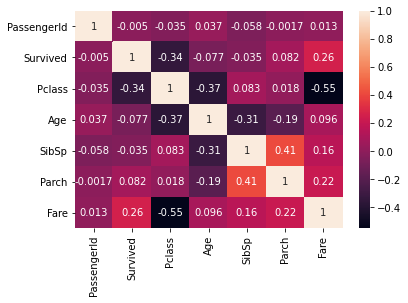

In [24]:
sns.heatmap(train.corr(), annot=True)
plt.savefig("images/correlations.png")

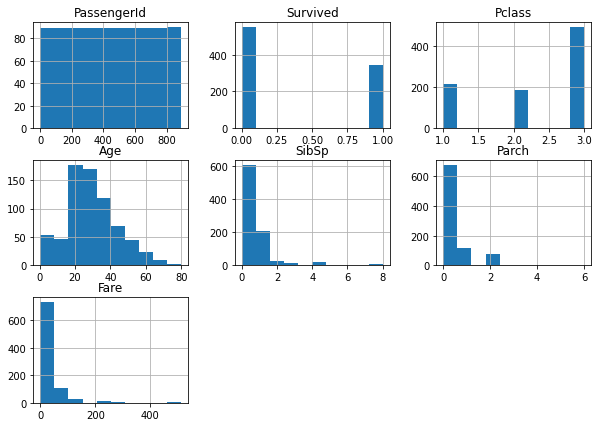

In [25]:
train.hist(bins=10, figsize=(10,7))
plt.savefig("images/distributions.png")

Tot not survived: 549
Tot survived:     342

% not survived: 0.62
% survived:     0.38


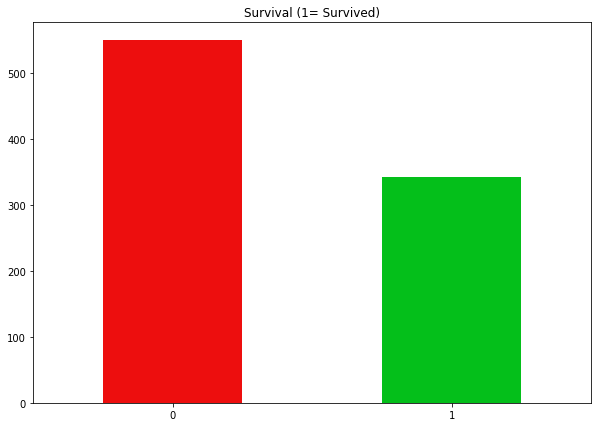

In [33]:
# survived/dead

train.Survived.value_counts().plot(kind="bar", figsize=(10, 7), color=("#ed0e0e", "#04bf1a"))  # alpha = bar opacity
plt.xticks(rotation=0)
plt.title("Survival (1= Survived)")
plt.savefig("images/survival-dead.png")


not_survived = len(train.loc[train.Survived == 0]["Survived"])
survived = len(train.loc[train.Survived == 1]["Survived"])
print("Tot not survived: {}".format(not_survived))
print("Tot survived:     {}".format(survived))

print("\n% not survived: {:.2f}".format(not_survived / len(train["Survived"])))
print("% survived:     {:.2f}".format(survived / len(train["Survived"])))

% female: 0.35
% male: 0.65


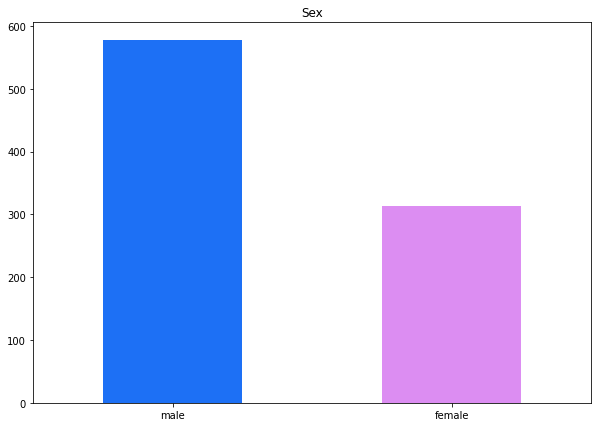

In [40]:
train.Sex.value_counts().plot(kind="bar", figsize=(10, 7), color=("#1d70f5", "#dc8df2"))
plt.xticks(rotation=0)
plt.title("Sex")
plt.savefig("images/male-female.png")

female = len(train.loc[train.Sex == "female"]["Sex"])   # 314
male = len(train.loc[train.Sex == "male"]["Sex"])       # 577

print("% female: {:.2f}".format(female / len(train["Sex"])))
print("% male: {:.2f}".format(male / len(train["Sex"])))

% S: 0.72
% C: 0.19
% Q: 0.09


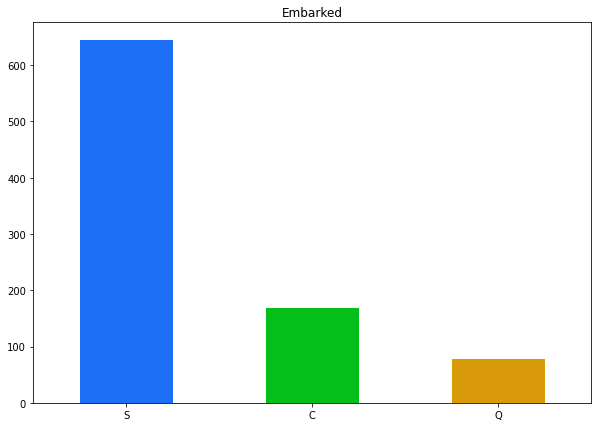

In [47]:
train.Embarked.value_counts().plot(kind="bar", figsize=(10, 7), color=["#1d70f5", "#04bf1a", "#d99a09"])
plt.xticks(rotation=0)
plt.title("Embarked")
plt.savefig("images/embarked.png")


S = len(train.loc[train.Embarked == "S"]["Embarked"])   # 644
C = len(train.loc[train.Embarked == "C"]["Embarked"])   # 168
Q = len(train.loc[train.Embarked == "Q"]["Embarked"])   # 77


print("% S: {:.2f}".format(S / len(train["Embarked"])))
print("% C: {:.2f}".format(C / len(train["Embarked"])))
print("% Q: {:.2f}".format(Q / len(train["Embarked"])))

% 1: 0.24
% 2: 0.21
% 3: 0.55


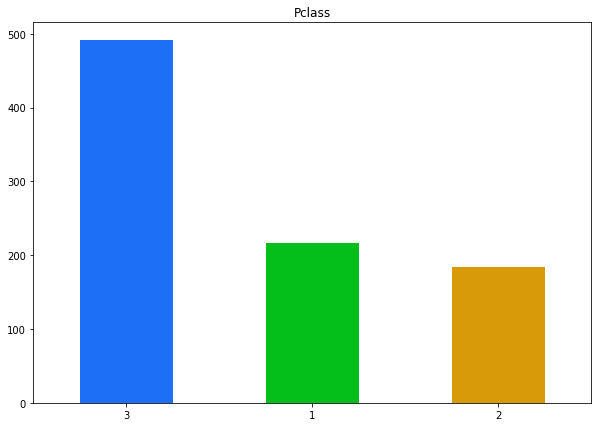

In [48]:
train.Pclass.value_counts().plot(kind="bar", figsize=(10, 7), color=["#1d70f5", "#04bf1a", "#d99a09"])
plt.xticks(rotation=0)
plt.title("Pclass")
plt.savefig("images/pclass.png")

first = len(train.loc[train.Pclass == 1]["Pclass"])    # 216
second = len(train.loc[train.Pclass == 2]["Pclass"])   # 184
third = len(train.loc[train.Pclass == 3]["Pclass"])    # 491


print("% 1: {:.2f}".format(first / len(train["Pclass"])))
print("% 2: {:.2f}".format(second / len(train["Pclass"])))
print("% 3: {:.2f}".format(third / len(train["Pclass"])))

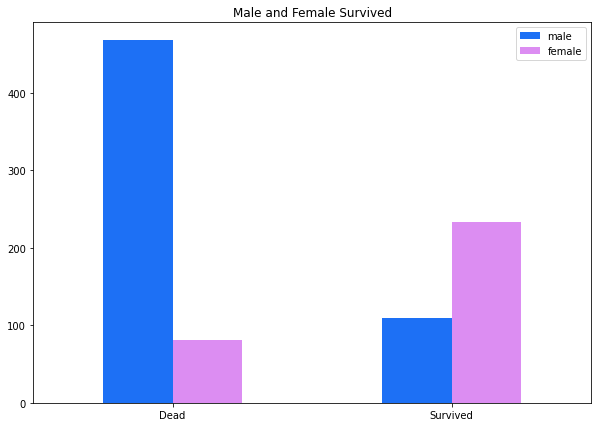

In [50]:
dead = train[train["Survived"] == 0]["Sex"].value_counts()
survived = train[train["Survived"] == 1]["Sex"].value_counts()

df = pd.DataFrame([dead, survived])
df.index = ["Dead", "Survived"]
df.plot(kind="bar", figsize=(10, 7), color=["#1d70f5", "#dc8df2"])
plt.title("Male and Female Survived")
plt.xticks(rotation=0)
plt.savefig("images/female-male-survived.png")

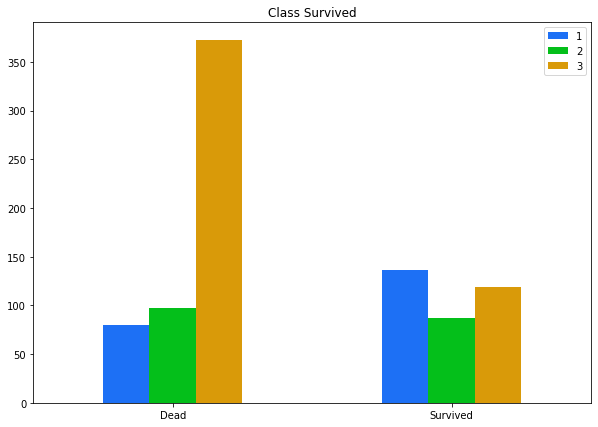

In [51]:
dead = train[train["Survived"] == 0]["Pclass"].value_counts()
survived = train[train["Survived"] == 1]["Pclass"].value_counts()

df = pd.DataFrame([dead, survived])
df.index = ["Dead", "Survived"]
df.plot(kind="bar", figsize=(10, 7), color=["#1d70f5", "#04bf1a", "#d99a09"])
plt.title("Class Survived")
plt.xticks(rotation=0)
plt.savefig("images/pclass-survived.png")

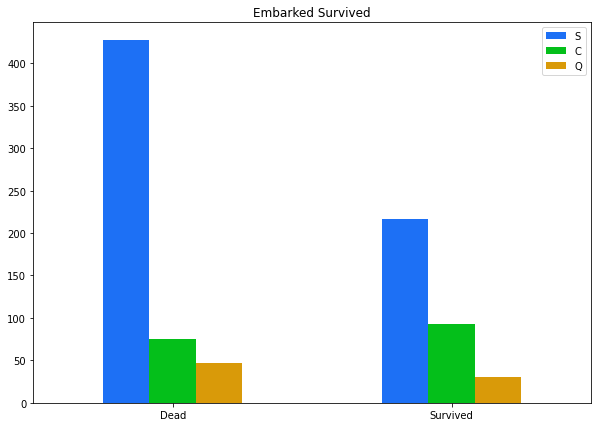

In [52]:
dead = train[train["Survived"] == 0]["Embarked"].value_counts()
survived = train[train["Survived"] == 1]["Embarked"].value_counts()

df = pd.DataFrame([dead, survived])
df.index = ["Dead", "Survived"]
df.plot(kind="bar", figsize=(10, 7), color=["#1d70f5", "#04bf1a", "#d99a09"])
plt.title("Embarked Survived")
plt.xticks(rotation=0)
plt.savefig("images/embarked-survived.png")

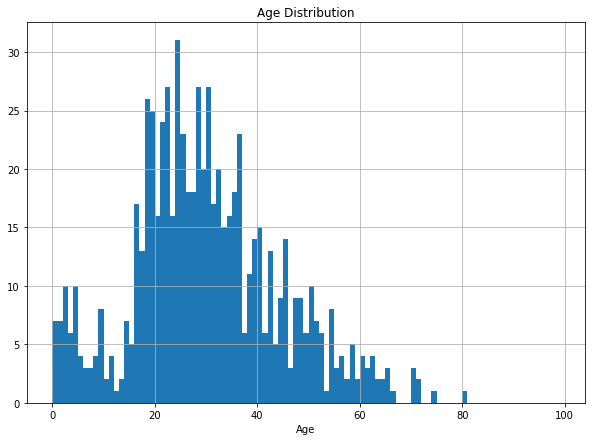

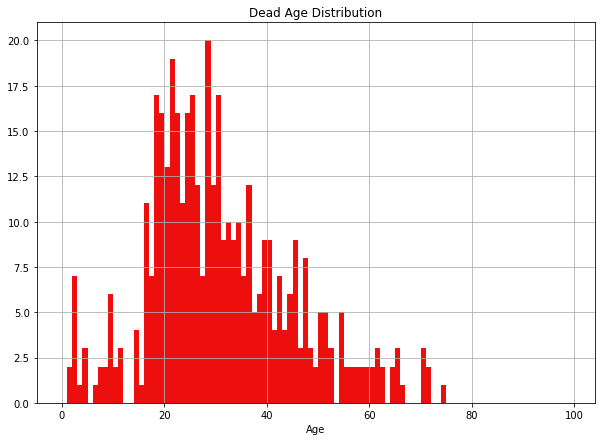

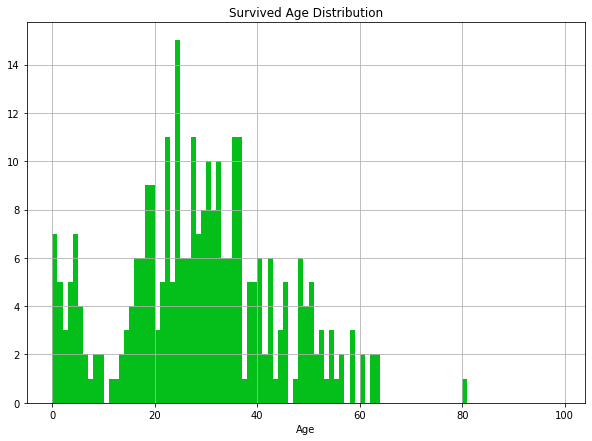

In [54]:
# age distribution
train["Age"].hist(bins=range(100), figsize=(10, 7))
plt.title("Age Distribution")
plt.xlabel("Age")
plt.savefig("images/age-distributions.png")
plt.show()

# age distribution survived/dead
dead = train[train["Survived"] == 0]
survived = train[train["Survived"] == 1]

# died age distribution
dead["Age"].hist(bins=range(100), figsize=(10, 7), color="#ed0e0e", label="Dead")
plt.xlabel("Age")
plt.title("Dead Age Distribution")
plt.savefig("images/age-dead-distributions.png")
plt.show()


# survived age distribution
survived["Age"].hist(bins=range(100), figsize=(10, 7), color="#04bf1a", label="Survived")
plt.xlabel("Age")
plt.title("Survived Age Distribution")
plt.savefig("images/age-survived-distributions.png")
plt.show()


In [55]:
# replace SibSp and Parch whit their sum

train["Sib + Parch"] = train["SibSp"] + train["Parch"]
train = train.drop(["SibSp", "Parch"], axis=1)
train.head()

test_data["Sib + Parch"] = test_data["SibSp"] +test_data["Parch"]
test_data = test_data.drop(["SibSp", "Parch"], axis=1)

In [56]:
# transform and pipeline
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.attribute_names]


# pipeline for numerical attributes
num_pipeline = Pipeline([
    ("select_numeric", DataFrameSelector(["Age", "Fare", "Sib + Parch"])),
    ("imputer", SimpleImputer(strategy="median")),   # for missing values
    ("std_scaler", StandardScaler())
])

num_pipeline.fit_transform(train)

array([[-0.56573646, -0.50244517,  0.05915988],
       [ 0.66386103,  0.78684529,  0.05915988],
       [-0.25833709, -0.48885426, -0.56097483],
       ...,
       [-0.1046374 , -0.17626324,  1.29942929],
       [-0.25833709, -0.04438104, -0.56097483],
       [ 0.20276197, -0.49237783, -0.56097483]])

In [57]:
# imputer for categorical columns
class MostFrequentImputer(BaseEstimator, TransformerMixin):

    def fit(self, X, y=None):
        self.most_frequent_ = pd.Series([X[c].value_counts().index[0] for c in X],
                                        index=X.columns)
        return self

    def transform(self, X, y=None):
        return X.fillna(self.most_frequent_)

# pipeline for categorical attributes
cat_pipeline = Pipeline([
    ("select_cat", DataFrameSelector(["Pclass", "Sex", "Embarked"])),
    ("imputer", MostFrequentImputer()),
    ("cat_encoder", OneHotEncoder(sparse=False))
])

cat_pipeline.fit_transform(train)

array([[0., 0., 1., ..., 0., 0., 1.],
       [1., 0., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 0., 1.],
       ...,
       [0., 0., 1., ..., 0., 0., 1.],
       [1., 0., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 1., 0.]])

In [58]:
# join numerical e categorical
full_pipeline = ColumnTransformer([
    ("num", num_pipeline, ["Age", "Sib + Parch", "Fare"]),
    ("cat", cat_pipeline, ["Pclass", "Sex", "Embarked"]),
])

train_prepared = full_pipeline.fit_transform(train)

In [59]:
X_train = full_pipeline.fit_transform(train)
y_train = train["Survived"]

In [60]:
# train the model (SVM)
svm_clf = SVC(gamma="auto")
svm_clf.fit(X_train, y_train)

# make prediction
X_test = full_pipeline.transform(test_data)
y_pred = svm_clf.predict(X_test)

# cross-validation for show how good the model is
svm_scores = cross_val_score(svm_clf, X_train, y_train, cv=10)
print("SVM Accuracy: {}".format(svm_scores.mean()))

SVM Accuracy: 0.8226841448189763


In [61]:
# fine-tune hyperparameters with GrindSearch
param_grid = {
    "C":[1, 10, 100, 1000],
    "gamma":[1, 0.1, 0.001, 0.0001], 
    "kernel":["linear", "rbf"]}

grid = GridSearchCV(SVC(),param_grid,refit = True, verbose=2)
grid.fit(X_train, y_train)

Fitting 5 folds for each of 32 candidates, totalling 160 fits
[CV] END ........................C=1, gamma=1, kernel=linear; total time=   0.0s
[CV] END ........................C=1, gamma=1, kernel=linear; total time=   0.0s
[CV] END ........................C=1, gamma=1, kernel=linear; total time=   0.0s
[CV] END ........................C=1, gamma=1, kernel=linear; total time=   0.0s
[CV] END ........................C=1, gamma=1, kernel=linear; total time=   0.0s
[CV] END ...........................C=1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END ...........................C=1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END ...........................C=1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END ...........................C=1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END ...........................C=1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END ......................C=1, gamma=0.1, kernel=linear; total time=   0.0s
[CV] END ......................C=1, gamma=0.1, 

GridSearchCV(estimator=SVC(),
             param_grid={'C': [1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.001, 0.0001],
                         'kernel': ['linear', 'rbf']},
             verbose=2)

In [62]:
print(grid.best_params_)

{'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}


In [63]:
# train the model (SVM)
svm_clf = SVC(C=10, gamma=0.1, kernel="rbf")
svm_clf.fit(X_train, y_train)

# make prediction
X_test = full_pipeline.transform(test_data)
y_pred = svm_clf.predict(X_test)

# cross-validation for show how good the model is
svm_2_scores = cross_val_score(svm_clf, X_train, y_train, cv=10)
print("SVM Accuracy: {}".format(svm_2_scores.mean()))

SVM Accuracy: 0.828314606741573


In [64]:
# train the model (RandomForest)

forest_clf = RandomForestClassifier(n_estimators=1000, random_state=42) # n_estimators=100, random_state=42 - 80 %
forest_scores = cross_val_score(forest_clf, X_train, y_train, cv=10)
print("RandomForest Accuracy: {}".format(forest_scores.mean())) 

RandomForest Accuracy: 0.8103870162297129


In [65]:
param_grid = { 
    'n_estimators': [200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}

grind_forest = GridSearchCV(RandomForestClassifier(), param_grid=param_grid, cv= 10)
grind_forest.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [4, 5, 6, 7, 8],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [200, 500]})

In [66]:
grind_forest.best_params_

{'criterion': 'gini',
 'max_depth': 8,
 'max_features': 'log2',
 'n_estimators': 500}

In [67]:
# train the model (RandomForest)

forest_clf = RandomForestClassifier(criterion="entropy", max_depth=8, max_features="auto", n_estimators=200, random_state=42) # n_estimators=100, random_state=42 - 80 %
forest_2_scores = cross_val_score(forest_clf, X_train, y_train, cv=10)

print("RandomForest 2 Accuracy: {}".format(forest_2_scores.mean()))  # 84%

RandomForest 2 Accuracy: 0.8406741573033708


In [68]:
# K-nearest neighbors
knn_clf = KNeighborsClassifier(n_neighbors=3)
knn_clf.fit(X_train, y_train)

y_pred = knn_clf.predict(X_test)
knn_score =  cross_val_score(knn_clf, X_train, y_train, cv=10)
print("K-nearest neighbors Accuracy: {}".format(knn_score.mean()))   #80

K-nearest neighbors Accuracy: 0.8037078651685393
